# EVAC Assessment 1 - Evolve a Player for the Video Game Snake


In [3]:
import random
import time
import turtle
import numpy as np
from deap import base
from deap import creator
from deap import tools
import logging
import matplotlib.pyplot as plt
import collections
%matplotlib inline

In [ ]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)
HEADLESS = True # True to run without graphical interface or False to run with the game showing

logging.basicConfig(level=logging.INFO) # Initializes the logging level used to output to console

In [ ]:
class DisplayGame:
    """Class for displaying the game when HEADLESS is set to False"""

    def __init__(self, XSIZE, YSIZE):
        """Initializes all aspects of the game including the board, snake and food pellets."""
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVAC Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE*20)+40,height=(YSIZE*20)+40)
        self.win.tracer(0)

        #Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("red")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        """Resets the display when the game is first ran"""
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake)-1):
            self.add_snake_segment()
        self.update_segment_positions(snake)
       
    def update_food(self,new_food):
        """Updates/draws food to the display"""
        self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)
        
    def update_segment_positions(self, snake):
        """Updates/draws each segment of the snake to the display"""
        self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i+1][1]-9)*20)+20, (((9-snake[i+1][0])*20)-10)-20)

    def add_snake_segment(self):
        """Draws and adds a new snake segment to the display"""
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color("green") # TODO: Change back to random colour generation before submission
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [ ]:
class Snake:
    """Class which contains the game logic for the game Snake"""

    def __init__(self, _XSIZE, _YSIZE):
        """Draws and adds a new snake segment to the display"""
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        """Resets the game after a run has finished"""
        self.snake = [[8,10], [8,9], [8,8], [8,7], [8,6], [8,5], [8,4], [8,3], [8,2], [8,1],[8,0]] # Initial snake co-ordinates [ypos,xpos]    
        self.food = self.place_food()
        self.snake_direction = "right"
        self.time_until_starve = self.XSIZE * self.YSIZE * 1.5 # TODO: 1. Check if this modification is allowed

    def place_food(self):
        """Randomly generates a location for the food, and regenerates it if spawned inside the snake"""
        self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        return( self.food )
    
    def update_snake_position(self):
        """Adds the new coordinate of the snakes head to the front of the snake coordinate list."""
        self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        """Returns True if snakes head coordinate is the same as the food location, otherwise removes the oldest coordinate 
            in the snake coordinate list (as a new one will be added for the movement of the head) and returns False."""
        if self.snake[0] == self.food:
            self.time_until_starve = self.XSIZE * self.YSIZE * 1.5
            return True
        else:
            self.time_until_starve -= 1    
            self.snake.pop()  # snake moves forward and so last tail item is removed
            return False
            
    def snake_turns_into_self(self):
        """Returns True if new snakes head coordinate is already in the body, otherwise False"""
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        """Returns True if new snakes head coordinate goes out of bounds, otherwise False"""
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
            return True
        else:
            return False

    # Sensor Functions

    def get_adj_coords(self):
        """Returns dictionary of adjacent coordinates to the snakes head"""
        adj_coords = {}
        dir_offsets = {"up": [-1, 0], ("down"): [+1, 0],
                   ("left"): [0, -1], ("right"): [0, +1]}
        for key, value in dir_offsets.items():
            adj_coords[key] = list(map(sum, zip(self.snake[0], value)))

        return adj_coords
        
    def sense_wall(self, coord):
        """Returns True if provided coordinate out of bounds, otherwise False"""
        return(coord[0] == 0 or coord[0] == (YSIZE-1) or coord[1] == 0 or coord[1] == (XSIZE-1))

    def sense_food(self, coord):
        """True if food is at provided coordinate, otherwise False"""
        return self.food == coord

    def sense_tail(self, coord):
        """Returns True if coordinate is a part of the snake, otherwise False"""
        return coord in self.snake
    
    def dist_to_food(self):
        """Calculates the manhattan distance to food""" # TODO: Check this works
        return abs(self.food[0]-self.snake[0][0]) + abs(self.food[1]-self.snake[0][1])
    
    def obstacle_check(self, coord):
        """Returns 0 if a tail or wall is found in a given direction, otherwise 1"""
        if self.sense_wall(coord):
            return 0
        elif self.sense_tail(coord):
            return 0
        else:
            return 1 
    
    def food_in_direction(self, direction):
        """Returns True if food is in a given direction, otherwise False"""
        snake_head = self.snake[0]
        if(direction == "up" and self.food[0] < snake_head[0]):
            return 1
        elif(direction == "down" and self.food[0] > snake_head[0]):
            return 1
        elif(direction == "left" and self.food[1] < snake_head[1]):
            return 1
        elif(direction == "right" and self.food[1] > snake_head[1]):
            return 1
        else:
            return 0

In [ ]:
class NeuralNetwork(object):
    '''Creates a fully connected/dense neural network with 2 hidden layers'''

    def __init__(self, numInput, numHidden1, numHidden2, numOutput):
        '''Initializes the neural network'''
        self.numInput = numInput + 1 # Add bias node for first hidden layer
        self.numHidden1 = numHidden1 + 1 # Adds bias node for second hidden layer
        self.numHidden2 = numHidden2
        self.numOutput = numOutput

        self.w_i_h1 = np.random.randn(self.numHidden1, self.numInput) 
        self.w_h1_h2 = np.random.randn(self.numHidden2, self.numHidden1) 
        self.w_h2_o = np.random.randn(self.numOutput, self.numHidden2)

        self.ReLU = lambda x : max(0,x)

    def softmax(self, x):
        '''Returns elements from last layer of network as a probability distribution which adds up to 1'''
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def feedForward(self, inputs):
        '''Takes the inputs & weights and processes the softmax output of the neural network'''
        inputsBias = inputs[:]                  # copies input array
        inputsBias.append(1)                    # adds bias value for hidden layer 1

        h1 = np.dot(self.w_i_h1, inputsBias)    # feed input to hidden layer 1
        h1 = [self.ReLU(x) for x in h1]         # activates hidden layer 1
        
        h1.append(1)                            # add bias value for hidden layer 2
               
        h2 = np.dot(self.w_h1_h2, h1)           # feed hidden layer 1 to hidden layer 2
        h2 = [self.ReLU(x) for x in h2]         # activate hidden layer 2

        output = np.dot(self.w_h2_o, h2)        # feed to output layer
        output = self.softmax(output)
        return output

    def getWeightsLinear(self):
        '''Returns the current weights set in the network'''
        flat_w_i_h1 = list(self.w_i_h1.flatten())
        flat_w_h1_h2 = list(self.w_h1_h2.flatten())
        flat_w_h2_o = list(self.w_h2_o.flatten())
        return( flat_w_i_h1 + flat_w_h1_h2 + flat_w_h2_o)

    def setWeightsLinear(self, Wgenome):
        '''Sets the weights for the network'''

        numWeights_I_H1 = (self.numHidden1-1) * self.numInput
        numWeights_H1_H2 = (self.numHidden2) * self.numHidden1

        self.w_i_h1 = np.array(Wgenome[:numWeights_I_H1])
        self.w_i_h1 = self.w_i_h1.reshape((self.numHidden1-1, self.numInput))
        
        self.w_h1_h2 = np.array(Wgenome[numWeights_I_H1:(numWeights_H1_H2+numWeights_I_H1)])
        self.w_h1_h2 = self.w_h1_h2.reshape((self.numHidden2, self.numHidden1))

        self.w_h2_o = np.array(Wgenome[(numWeights_H1_H2+numWeights_I_H1):])
        self.w_h2_o = self.w_h2_o.reshape((self.numOutput, self.numHidden2))

In [ ]:
def run_game(display, snake_game, headless, network):
    '''Runs through a game simulation, using the neural network to make decisions on the snakes movement. 
        Returns the final score the snake achieved before a loss condition was met.'''

    # Resets the score, game & display
    score = 0
    snake_game.reset()
    if not headless:
        display.reset(snake_game.snake)
        display.win.update()
    snake_game.place_food()
    game_over = False

    while not game_over:      
        adj_coords= snake_game.get_adj_coords()

        
        # Gets softmax output of the neural network decision
        decision = network.feedForward([snake_game.obstacle_check(adj_coords["up"]),
                                        snake_game.obstacle_check(adj_coords["down"]),
                                        snake_game.obstacle_check(adj_coords["left"]),
                                        snake_game.obstacle_check(adj_coords["right"]),
                                        snake_game.sense_food(adj_coords["up"]),
                                        snake_game.sense_food(adj_coords["down"]),
                                        snake_game.sense_food(adj_coords["left"]),
                                        snake_game.sense_food(adj_coords["right"]),
                                        snake_game.food_in_direction("up"), 
                                        snake_game.food_in_direction("down"),
                                        snake_game.food_in_direction("left"),
                                        snake_game.food_in_direction("right") 
                                        ])
        
        # Converts softmax output to output direction and sets it
        directions = ["up", "down", "left", "right"]
        direction = np.argmax(decision)
        snake_game.snake_direction = directions[direction]
            
        snake_game.update_snake_position()

        # Checks if food is eaten and replaces food + increments score
        if snake_game.food_eaten():
            snake_game.place_food()
            score += 1
            if not headless: display.add_snake_segment()

        # Ends game if the snake runs into itself
        if snake_game.snake_turns_into_self():
            game_over = True

        # Ends game if the snake hits a wall
        if snake_game.snake_hit_wall():
            game_over = True
        
        # Ends game if snake starves
        if snake_game.time_until_starve == 0: # TODO: Check if allowed
            game_over = True

        # Updates display when not running in headless mode
        if not headless:       
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()

            time.sleep(0.01)     # Change to change update rate of the game

    if not headless: turtle.done()
    
    return score


In [ ]:
# Initializes game (and display if not running in headless)
if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)
snake_game = Snake(XSIZE,YSIZE)

# Initializes neural network
numInputNodes = 12
numHiddenNodes1 = 16
numHiddenNodes2 = 12
numOutputNodes = 4
network = NeuralNetwork(numInputNodes, numHiddenNodes1, numHiddenNodes2, numOutputNodes)

# Calculates the size of the individual using input, output and hidden layer neuron counts (accounting for bias nodes for hidden layers)
IND_SIZE = ((numInputNodes+1) * numHiddenNodes1) + ((numHiddenNodes1+1) * numHiddenNodes2) + (numHiddenNodes2 * numOutputNodes)

# Creates single objective maximizing fitness named FitnessMax
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# Creates an individual with a list of attributes using previously created FitnessMax
creator.create("Individual", list, fitness=creator.FitnessMax)

def evaluate(individual, myNet, snake_game):
    '''Returns the fitness of the individual after evaluating performance from game simulation'''
    myNet.setWeightsLinear(individual)   # Load the individual's weights into the neural network
    fitness = run_game(display, snake_game, HEADLESS, myNet) # Evaluate the individual by running the game (discuss)
    return fitness,

# Registers functions to create individuals who's genes are random float values (uniformly distributed between -1 and 1)
toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, -1.0, 1.0)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=IND_SIZE)

# Registers functions to evaluate individuals
toolbox.register("evaluate", evaluate)

# Registers function to select, mate and mutate individuals
toolbox.register("select", tools.selTournament, tournsize = 50)
toolbox.register("mate", tools.cxOnePoint)
toolbox.register("mutate", tools.mutGaussian, mu=0.0, sigma=0.2, indpb=0.05)


# Registers function to generate initial population
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registers the statistics & logbook that will be logged during the GA
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)
logbook = tools.Logbook()

In [ ]:
# Initializes population
population = toolbox.population(n=500)

# Calculates the initial fitness values for each individual and sets them
fitnesses = [toolbox.evaluate(individual, network, snake_game) for individual in population]
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# Number of generations the GA will compute
NGEN, CXPB = 150, 0.2

# Genetic Algorithm
for g in range(NGEN):
    logging.info("Running generation " + str(g))
   
    
    # Selects number of individuals equal to population length 
    offspring = toolbox.select(population, len(population))
    # Includes duplicates so clones all individuals
    offspring = list(map(toolbox.clone, offspring))

     test = [indiv.fitness.values for indiv in offspring]
    counter = collections.Counter(test)
    print("Number of 0.0 fitnesses selected: ", counter[(0.0,)])

    # Performs crossover on 2 individuals based on previously defined probability
    for indiv1, indiv2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(indiv1, indiv2)
            del indiv1.fitness.values
            del indiv2.fitness.values

    # Mutates offspring based on previously defined probability #TODO: Modify probability/algorithm type?
    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values   # Deletes old fitness values
          
    # Recalculates fitness values for mutated offspring
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = [toolbox.evaluate(individual, network, snake_game) for individual in invalid_ind]
    for ind, fit in zip(invalid_ind, fitnesses):
         ind.fitness.values = fit
       
    population[:] = offspring   # Replaces old population with new mutated offspring

    # Compiles & records the statistics for the new generation
    record = stats.compile(population)
    logging.info(">> Min Fruit Eaten     - " + str(record["min"]))  
    logging.info(">> Average Fruit Eaten - " + str(record["avg"]))  
    logging.info(">> Max Fruit Eaten     - " + str(record["max"]))      
    logbook.record(gen=g, **record)         

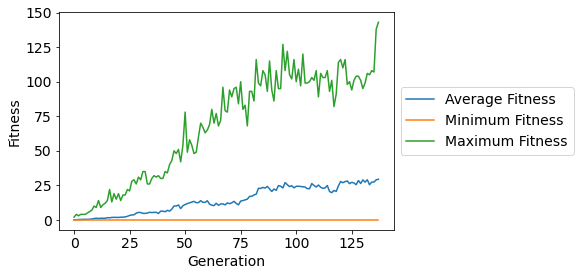

In [4]:
# Sets the header & statistics to select from logbook
# logbook.header = "gen", "avg", "evals", "std", "min", "max"
# gen, _min, _max, average, standard_dev = logbook.select("gen", "min", "max", "avg", "std")
# print(logbook.select("gen"))
# print(logbook.select("avg"))
# print(logbook.select("min"))
# print(logbook.select("max"))
# print(logbook)

gen = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]
average = [0.104, 0.204, 0.314, 0.33, 0.414, 0.428, 0.406, 0.466, 0.682, 1.002, 1.268, 1.034, 1.204, 1.21, 1.202, 1.6, 1.54, 1.79, 1.854, 1.798, 1.794, 1.99, 1.982, 2.172, 2.6, 3.226, 3.578, 3.724, 4.89, 5.432, 5.356, 4.73, 4.736, 4.93, 5.552, 5.292, 5.478, 5.476, 4.684, 6.336, 6.39, 5.894, 6.93, 6.366, 7.786, 10.098, 10.054, 10.824, 8.174, 10.26, 11.148, 11.834, 12.376, 12.902, 13.398, 12.46, 12.5, 13.944, 12.704, 12.704, 13.86, 11.402, 10.672, 10.304, 12.04, 10.578, 11.52, 11.602, 10.876, 12.278, 11.768, 12.332, 13.432, 11.972, 10.876, 13.626, 13.984, 14.496, 15.022, 17.022, 17.088, 18.06, 18.626, 22.864, 22.766, 23.494, 23.036, 24.26, 22.384, 20.584, 22.376, 21.39, 24.85, 24.39, 23.118, 27.0, 25.456, 24.114, 24.762, 23.194, 24.298, 24.386, 24.21, 23.98, 23.754, 22.612, 22.578, 26.292, 24.94, 23.784, 25.252, 23.632, 22.836, 23.144, 24.908, 20.572, 19.728, 21.32, 20.568, 24.68, 27.786, 26.916, 27.714, 28.164, 26.212, 27.232, 26.716, 25.474, 28.52, 26.308, 28.964, 27.344, 29.03, 25.46, 27.378, 27.408, 29.01, 29.412]
_min = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
_max =[2.0, 4.0, 3.0, 4.0, 4.0, 4.0, 5.0, 6.0, 7.0, 10.0, 9.0, 14.0, 9.0, 11.0, 12.0, 14.0, 22.0, 13.0, 19.0, 15.0, 19.0, 14.0, 18.0, 18.0, 22.0, 21.0, 28.0, 29.0, 26.0, 31.0, 29.0, 35.0, 35.0, 26.0, 26.0, 30.0, 32.0, 31.0, 32.0, 30.0, 30.0, 35.0, 34.0, 40.0, 43.0, 50.0, 48.0, 51.0, 42.0, 54.0, 78.0, 49.0, 58.0, 54.0, 48.0, 49.0, 60.0, 70.0, 67.0, 63.0, 65.0, 69.0, 80.0, 70.0, 77.0, 68.0, 72.0, 96.0, 79.0, 78.0, 94.0, 89.0, 95.0, 96.0, 84.0, 100.0, 80.0, 83.0, 68.0, 93.0, 93.0, 86.0, 116.0, 99.0, 97.0, 108.0, 105.0, 93.0, 115.0, 94.0, 86.0, 108.0, 95.0, 95.0, 127.0, 108.0, 122.0, 105.0, 102.0, 116.0, 100.0, 109.0, 97.0, 120.0, 99.0, 99.0, 100.0, 103.0, 101.0, 108.0, 89.0, 106.0, 103.0, 103.0, 108.0, 93.0, 101.0, 82.0, 91.0, 114.0, 116.0, 110.0, 116.0, 98.0, 100.0, 94.0, 101.0, 104.0, 104.0, 101.0, 95.0, 99.0, 106.0, 105.0, 108.0, 107.0, 138.0, 143.0]

# Draws graphs 
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig, ax = plt.subplots()

ax.set_xlabel("Generation")
ax.set_ylabel("Fitness")

line1 = ax.plot(gen, average)
line2 = ax.plot(gen, _min)
line3 = ax.plot(gen, _max)

# Adds key to graph
ax.legend(["Average Fitness", "Minimum Fitness", "Maximum Fitness"], loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:

# Takes weights of the best individual and runs in non-headless mode
# bestInd = tools.selBest(population, 1)[0]
# network.setWeightsLinear(bestInd)
# # weights of decent snake from big run
# # weights = [-3.3786318224249774, 1.264706228369047, -0.40942301323576036, 0.8228627733512951, 1.2952849514161144, -2.161447552842574, 2.459304604445068, 0.751959693871249, 0.2646987606130422, 0.44054769982886344, 2.963415085453179, -1.4734280754553195, 1.9762563570191047, -1.3980643317127417, 1.565652804914855, -1.3436918453278417, 3.2884625073498817, -0.07067514264084776, 0.16989418906325993, -1.3506191153128582, -0.9577401209982983, -0.6868746770233645, 0.41317660463818046, -1.17013356033095, -1.6907316878337038, -0.7788865033646469, 1.5457942459648732, 0.7252479850234728, -0.5003985396381967, 1.3279832030358585, -0.46304647770929447, -0.8531771278308292, 0.8411415781462619, -0.5037411765896797, -2.4331300129641327, 0.7215281054941072, 0.3149669933639485, -1.6099786395606295, -1.122140275792487, 1.1926320696927895, -1.2613199315404577, 0.7667372744315759, 0.40390578170828906, -1.5931007716499335, 0.5809589765334454, -0.7390772483839543, 1.1664280651907746, -1.7328894002113566, 0.24755009309092743, -2.4901934640909222, -1.4150369875600253, -0.03748343761100241, 2.765686616714359, 0.8762267072228441, -1.4213291568860333, 3.5029434678489677, 0.09738587437680091, -2.3196384005626065, 0.8214933026594639, 1.409549625326027, -2.8920796535874858, -1.8250013504147193, 0.175446620348488, -0.9249621509086291, -0.5790439502407716, -1.6974727829158998, -0.2750526824653321, 1.977987168747408, -0.8937438988830115, -0.4315991416671394, 0.025314561048932427, 1.162685851111196, 0.48690643714042237, -0.5540900055111977, -1.8285726130963185, -0.11830786709438537, -2.073279629019206, -0.24078189503546168, 0.18988356617971125, -2.7061506128721833, 1.54096148072729, -1.6797703537519966, 1.7952608810601667, 1.0405412899357096, -0.8299709727753755, 1.1732086636728498, -2.0563440331152365, 1.8928593971714958, 0.3016272459407501, -0.21737236147597444, 2.780865459721678, -1.698104067812116, 0.07212796237875763, -0.6270463436257026, 2.134186523898742, 2.3755549136388714, -0.9885587957329299, 2.626775872225696, 1.2980598589378585, -0.3922580636680093, 0.19963460387160675, -0.9757090918322109, -1.345411808022169, -0.6679567219504612, 0.6327451931594831, -0.5717976253665514, -1.9469242806155815, -2.385350170221946, -2.3017829074581617, 2.28285019896275, 1.693795645655068, 0.03289688815866365, 0.013906957581289445, 0.25736693214505857, 1.1178970011086455, 1.913850154888052, 0.3899407778733879, 1.1987144944005508, 0.6068250996781694, 0.07595431461180863, -0.30755572429590405, 2.016148507616494, -0.19879195748695275, 0.01666275978799664, -0.7957781939212187, 1.3115189557370153, 0.286758035272611, -1.1243784045476288, -0.7506689784844444, 0.18619825439443896, -2.495485320926148, -0.8315403136953066, -1.6403088104311934, -1.6262008408799984, 2.2436087651709054, -0.6572400275541929, -2.2765733522893448, 0.7782739357757492, -0.30973410897232906, 1.1788342043967561, 2.9279597081311413, 0.6008268849732972, -0.35101848094385146, 1.4656611216952873, 0.10420528691858252, 2.3384091806706815, 1.7074779302191798, 0.3416018337245642, 1.3827825827583993, -2.875759178814153, 1.438384957885212, 1.1027367924491582, 0.9993624576536544, 0.26083251593376755, 0.054701320621820454, 1.4655376304104868, 0.35023670109319144, -1.5659338117116186, 3.1079242952812236, -0.44526535649690535, -0.39533167403988445, 0.6611150644093164, -0.5389959954640773, -0.4182004391286605, 2.955947131021676, 0.3064480522887835, -1.7117124375560564, -0.5603912146026477, 0.00785738974827982, 1.5392347912772273, 1.633768473137616, -0.9695656601737563, -1.7235285270958494, 0.26860457026710083, -1.60069371993584, -1.0563595859268577, 2.6338738144421763, -0.47869633315876126, -0.8625043965138284, 1.003024320293217, -0.7329651782946017, 0.40166933527133575, -0.9305524074729066, 0.3617315187585298, 0.9935343713239062, -1.2712403993634183, -1.5332277218629815, 0.3318209295407418, -0.4072495674771841, 0.20748709783664726, 0.2826262877094916, -0.103355920901315, -0.3408923624099704, 0.2541048963551895, 1.26182027075251, 0.3354822262508063, 2.4380963314587785, 1.0637524808109353, -1.796672777709277, -0.015629020707459043, -0.07424017006499205, -0.9038316919718722, -0.1827430646643367, -1.2913391261454543, -1.2379288263663581, -0.7487917045399035, 0.9769312631345152, 0.07558491189238548, -1.273553471360424, 0.7302827255358089, 0.5811170784730877, -0.6289949068938911, -3.8870496423644054, -0.368553989918404, -1.095522846316345, -1.0582601756751056, -3.0776000943075146, 1.2410361991161125, 0.7614820660148116, -2.0115772990078544, 1.2517335430894785, -0.5470880540146368, -0.27635297357270516, -1.4357963522325188, 1.1491892797514458, -0.7583889978868158, 2.0933905780342696, -2.4225188846307653, 1.9034975242608294, 0.24965543046521244, -1.0172814243967296, -1.237400942655199, 1.7736358537498247, 0.3454665583689715, -3.082502515149337, 0.012885844550694383, 0.3294242844258688, -2.406155957010417, 0.7386854729906833, -0.17109848129854108, 0.4106663915363994, -2.898160947438728, 1.2978371795543842, -1.5318492894265647, -1.0638426962667027, -0.046965017241237965, -0.09582964593453899, 0.08285151947081876, 0.9859427107618864, 0.4606465736620381, 1.421534861815946, 1.7931002891968812, -3.4588769277993894, 0.18651211328753767, 1.8866480654929214, -1.4501116185459169, 1.7622605912779543, -1.1709581137304979, -0.3229764295885535, -0.9572365343703699, -0.8075790254877449, -1.2359866287092056, -0.10360954244547194, -0.03058811270930377, -3.099540754444425, 2.1660109127929177, 1.3512202043320023, -2.8114098868745256, -0.4447292428425811, 1.188511748895626, 0.6783979832714906, -0.317051585775403, -0.10924801409813643, 1.8539060720780678, 0.7588061628484052, -1.1268542654085967, -0.2888938610335625, 0.9309236210923635, 0.7821511403377567, 2.7907710204784952, 1.1696090640145176, -1.3366780152148885, 1.0506836982345986, -0.23926185015379092, -1.5530935514625401, 2.050760216281348, -0.06849773655372443, 1.550647026113014, 2.3071199299430063, -1.1748096897901315, 0.9651293368915005, -0.23503703495422576, 3.2832712811259546, -0.47699291331564486, -2.764534616190909, -0.659049453400496, 1.8657276293350016, 1.8615638475458378, -1.1825990521860548, -1.5762237948816398, -1.1377258235995373, -0.264087089171003, -3.370727452998959, 1.0030994638539028, 2.2389755052495177, -3.319809284042486, -1.0104396750187883, -0.37777789881967405, 3.160653489380219, 0.7482208631679532, 0.9105473005189015, -1.2071592931617545]
# # weights = [-0.1509374017191777, 0.41518100187732443, -0.6071938258315646, -0.7771555546167942, 0.6033669278735966, -0.6355296651003062, 0.10173970518854483, 0.984858704491256, -0.3481118859388402, -0.6980978552297408, 0.3456725455794208, 1.0081370786221688, 0.40898030433587285, 1.3297521968403532, 1.5197457561103984, -0.9809713064450931, 0.7381052986660284, 0.4700334736751531, 0.28052457449530555, 0.5247618284170215, 0.21942122260639835, -0.3098101031974913, 0.40852778267531886, -0.8591478833343901, -0.0367290664227079, -1.2595101898373438, 0.1317435459041501, 0.161659732541819, -0.6380661389940538, -0.8811462921069291, -1.4619367137540702, -0.7963567844806759, 0.89726007413653, 0.22668481065409207, -1.2219388092628014, -1.1460583704889051, -0.3297436627431864, 1.4507789037055872, -0.5038686477669931, 0.3013002695718274, -0.47595391442956414, -0.947277100521831, 0.6212997837055523, -1.2881786525732577, 2.6270103682360397, 0.9086794698235998, 0.8327352770515092, -1.4147294555876073, 0.9495009831749763, -0.6540949418758893, 1.40531565217911, 1.228514543970587, 0.6931961767929942, -0.19385438951746822, -0.481807751435666, 1.5954127152781645, 0.6084739721840167, 0.12733071873503893, 0.7147434857273269, 0.5293600731738861, -0.11177496301409318, -0.27123852531136977, 0.3773906621787842, 0.48004088711334436, 1.0345620468284429, 0.3888368347410954, -0.381153019223474, -0.7642787538669076, -0.6337929451594304, 0.1918026045006277, -0.6597235389618161, -0.39916252592471746, 0.15847124050132166, 1.4650179602864566, 1.0437882031730663, -0.8906912463734237, -0.5318301347892511, 0.7844957377575965, 0.2257517892819575, 1.5995838242158262, 0.748199016046794, -1.286456002010863, 0.7828847234700609, 0.06732973542815032, 0.8177348959802035, -0.06486546772294594, 0.21228284926447377, 1.2036775759262794, 0.24438655267181275, -0.5690745151977994, -0.4264775196733027, -2.481251885350836, -0.7962084154102504, 0.2891644940412902, -0.3996195446629978, 0.21225603506552426, 0.3088366034928347, -1.082488556090249, 0.20429282608963195, -1.7636616495939297, -0.47190133785044774, 0.11153570588320666, -0.5121254872941783, -0.6144335081572734, -0.05603635437078832, -0.2899783944822951, -1.400863491405516, -0.07080177186455838, 0.5491964873817835, 1.814325920407179, -1.4579455035829927, 1.3027670810400227, -1.7775214393833076, 1.4213673368695332, 0.07345399971485109, 1.7519366224517483, 0.1367464295040458, 0.469630159477716, -0.13514144591782884, 0.5378023163916272, 1.106495038823048, -0.43203138086590365, 0.04677051045736652, -0.6078284228681886, -0.5977346343177112, -0.397857553731712, 1.3687343009254647, -0.32002567895473566, 0.31116466302687, -0.30089002350368305, 1.6272684908386394, 0.47379651821136004, 0.6080362309674842, -0.5944349277065184, 0.14851575270391557, -1.3855600688624374, 1.8640139194144112, -0.35387859974428215, 0.6869582773250107, 0.7060535546848477, 0.23900543813211153, 1.044319784246085, -1.5350954944211928, 1.2096130665576752, 1.1587371126275468, -1.2995744103342308, 0.03976767136774306, 0.5843251279987062, -0.5121896620001114, -0.5387431809360574, -0.09220721000137644, 1.103576094615586, 0.10774183592147481, 1.0568433391789853, 0.19118503240091173, 0.48936207038659885, 0.09801858387026224, 0.4937275891589257, 0.7180806143775691, 0.5396654277521495, 0.060151329928144176, 0.6752504152529055, 0.6594419440803635, -2.2426158702225374, 1.0776789967172051, -0.573074139137002, 1.2770683073583535, 0.6293838453800126, 1.5413422898819031, -1.6342465740780263, 0.9992403264826152, 0.25220482277827067, -1.2516644686958482, -1.4112966016235395, 0.5620434977537787, -1.1180358633210892, -0.7827572574859974, -0.7538746375387029, -0.05998753147042732, 2.028553194845889, 0.33606439923190407, -0.7202149626606045, 0.2565914018007377, -0.26077444776850933, -1.8615081271897571, -0.7511345408998196, 0.7240625493830904, 0.4864787934492981, 0.5695761170461086, 2.1031014297058697, 1.2723013814929394, -2.7139096888550247, 1.340146910960506, 0.7785617359648296, 1.2389461496304688, -0.7548520640615738, -2.342828919407905, -0.2387131132841206, 0.4138580177688629, -0.8268155920549665, 0.34280504799442296, 0.7444436002011517, -0.8471099953482969, 0.3681807543181066, -1.3883439195349918, -0.8286298054921213, 0.9213836654293801, 0.33679612113774576, 0.26186320177734623, 0.9544148089020106, -1.1433631651569818, 1.6749258282273396, 0.02779007687510282, 0.40566755095130824, 1.1387961948234029, 2.023420024396558, -1.5945296350902172, -0.607836510393571, 0.4024722986063149, 1.423181662063865, -0.4814155382473717, 1.5662224602296053, 1.412082629931871, -1.0026180762976011, -2.107958426445956, 0.6575984357976694, -0.6661739532325792, -0.2676365883490062, 1.1416177912169285, 1.1631605524002628, -1.199254583092595, -0.27049592722860144, 1.7911293116936378, 0.4195018384409323, 0.12920108786905843, -0.6651394730031148, 1.0681181186795379, -0.33820568145879804, 1.2825257209870273, 2.109175093202981, 0.16014637947021948, -0.9904178847091665, 1.093791923051392, 1.64939566452986, -1.672674877752397, -0.026080894176617686, 0.6182797932706042, -1.4884741177627498, -1.2558829029842662, 0.32377430537405516, 1.7514444182335631, 0.343345750575825, -1.0867158981341398, 0.24413450438635168, 1.1836526577021558, -1.1770289316381444, -0.17226986005695488, -1.0229075096274443, -1.1633279066358673, -0.8725717706921337, 0.13398929661526454, 0.3985032712110736, 2.2665004721847346, 0.1451632477453174, -1.5133794824341893, 0.49854797613467644, -0.21458614745683538, 0.6023479067086499, 1.7039780858392066, -1.2560949079218386, -0.21311499509043186, -0.7893340683023868, -0.3898895471730173, 0.8112941272227414, 1.4128965719870894, 0.5845373883640237, 0.999531836278532, 0.29947848650399145, 1.3013801489532406, 0.7091701505800043, -0.7143033261674536, 1.408803498138621, -0.6357268655111757, -2.4171211170005984, -0.07120036731467735, -0.062355613566769996, 0.9718371482417103, -2.281860281661401, -0.8822231664913572, -0.810087931604742, -0.5586421326562397, -0.8243855172238923, 0.32203362467624785, 0.06054910052737736, 1.8072886950883875, -1.643358935060061, -0.6225394756315401, 0.3933511548657163, 0.9447997465915798, -1.382250147249837, 1.16429905433615, 0.2913489384157819, -1.1552720208098324, 0.6607967125599139, -1.2681342361730237, -1.0684444549591, -2.8151073284462402, -0.766574092948181, -0.5653807617223394, -0.43366161553356186, -0.5042313873763526, -0.048597944677627236, -0.45719663547256856, -0.34204774137007293, 0.7156315166899109, 0.9708854785680437, 0.30157144686055914, -0.4318824655276863, -0.32054528255352055, 1.1219205838643602, 0.08023770991330614, -0.9949433935780735, -0.39071324262008617, 0.3155824526814191, -1.2000210260472, 1.7603425502341588, -0.31909611552357164, -0.32463212628633803, -1.66310036463099, 0.7448847733630075, 0.1931263777127452, -0.1418635481949426, -0.16334270863220374, 0.1869093367838821, 0.05037770224988855, -0.6671316270669357, 0.10444676293646948, -0.40494179473320935, 1.9321524153049632, -2.1409825041292834, -0.6802664424427178, -0.4496311437927294, 1.9102942209610256, -0.6361238223544866, 0.47814030010449154, 0.7532191106885984, -1.6812988163338514, 0.06488036783908745, -1.361259149242511, 0.9366652282386208, 0.897361533983732, -0.08106894950711457, 0.8337710686218052, 0.8064756481851755, 0.3270031261867631, -0.027153784740839848, 1.6523083750066405, 1.4976012305292157, 0.5749535514792175, -0.24247129367026737, 0.24774948070998942, -0.22634762047397783, 0.857319186110886, -0.7916901692298923, 1.2713361993186987, 0.21834855178596524, -0.04490565846540101, -1.0084458799719782, 0.007099471510386236, -0.09703696234969691, 2.257937281024789, 0.04030128134830013, -0.5169980501519851, -0.05736361900711087, 0.9868180310309184, 0.13142891334706996, -0.9700040441216109, 0.41156314047358855, 0.5901912649388815, -1.7798090475213975, 0.2468057052384493, -0.3665400138078611, 1.2222181408662616, 0.38137262935356764, -0.3802874129943, -0.42797183955115764, -1.3797777539265959, -1.6912223214784, 0.3589786324768339, -0.29865904131475796, 0.7355039408129519, 0.5542903313994645, 1.978428765023012, -0.3388728895292524, 0.7982053354567438, -1.7892718620914352, 0.8256046573118125, 1.8729391319729125, -1.5769666744744841, 0.8106348273362695, -1.1565120987122357, 0.2535729758511357, 1.747141194705031, 0.055487860188705995, -1.652625384202999, 0.9179348516635734, 0.2560858414338692, -2.4457914631696727, 0.003687496151174651, 1.3654795740224517, -0.27327371759472174, -0.4638222669261475, 1.7351636401501915, 1.0277448580770125, -1.1750319472554422, -0.7825952575289827, 0.5105971816402131, -0.6283213300417325, -1.3033432382070531, 1.5465948228974937, -0.834422342244195, 0.1330167342930712, 0.8410736875525944, 0.5068798515647265, -0.09423778246157762, 0.9080784911185155, -2.8006726687754964, 1.3832986319132987, 0.15823674885085945, 0.025998491527093187, 0.8808700536200954, -1.8048565897818023, 1.7664179694307405, -0.5906047330833331, -1.0653187530243298, 0.03606321207028543, -1.202403275828034, 0.1815612039561375, -0.5093301603697431, -1.1112040643090848, -1.3308790256455176, -0.2382795895848124, 0.9487122678645683, 0.9352146994517883, 0.9259235624239077, -0.05869641452884167, 1.6019265490247, 0.3720342368086303, -0.47717596932702044, 0.48440656543660643, 1.3890374475394642, 0.9790766180109216, -0.40914817286559313, 1.171851667164663, -0.5980337752375694, -2.3089147214431023, 0.11050299687379433, 0.1579108026004014, 0.14837267232940554, -1.4909566684514945]
# network.setWeightsLinear(weights)
# display = DisplayGame(XSIZE,YSIZE)
# run_game(display, snake_game, False, network)
# turtle.Screen().bye()

print(max(_max))

NameError: name 'population' is not defined